# CRF Model for Sentiment Analysis

In this notebook, we implement a Conditional Random Field (CRF) model to perform sentiment analysis on textual data. This task is part of the CO3117 Machine Learning project, focusing on comparing several ML models across a unified use case.

**Use Case**: Sentiment classification (positive vs. negative)  
**Dataset**: [Twitter and Reddit Sentimental Analysis Dataset](https://www.kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset)  

The dataset combines tweets and Reddit comments labeled as either positive or negative. To enhance preprocessing and feature extraction, we also leverage the following external resources:

- **Sentiment lexicons**: Two lists of positive and negative words from [this Kaggle dataset](https://www.kaggle.com/datasets/sireeshajasti/sentiwords), originally published in:  
  *Bing Liu, Minqing Hu and Junsheng Cheng. “Opinion Observer: Analyzing and Comparing Opinions on the Web.” WWW-2005, Chiba, Japan.*

- **Stopwords**: A predefined list of stopwords retrieved via [GeeksforGeeks – NLTK stopword removal](https://www.geeksforgeeks.org/removing-stop-words-nltk-python/)

- **Text-cleaning patterns**: A dictionnary of common internet abbreviations and custom cleaning functions adapted from this [Kaggle notebook](https://www.kaggle.com/code/vshantam/twitter-and-reddit-sentiments-lstm-embeddings)

This notebook is divided in 6 parts :
- 1) Setup and Imports
- 2) Data Preprocessing
- 3) Featurization
- 4) CRF Model Training
- 5) Results Analysis

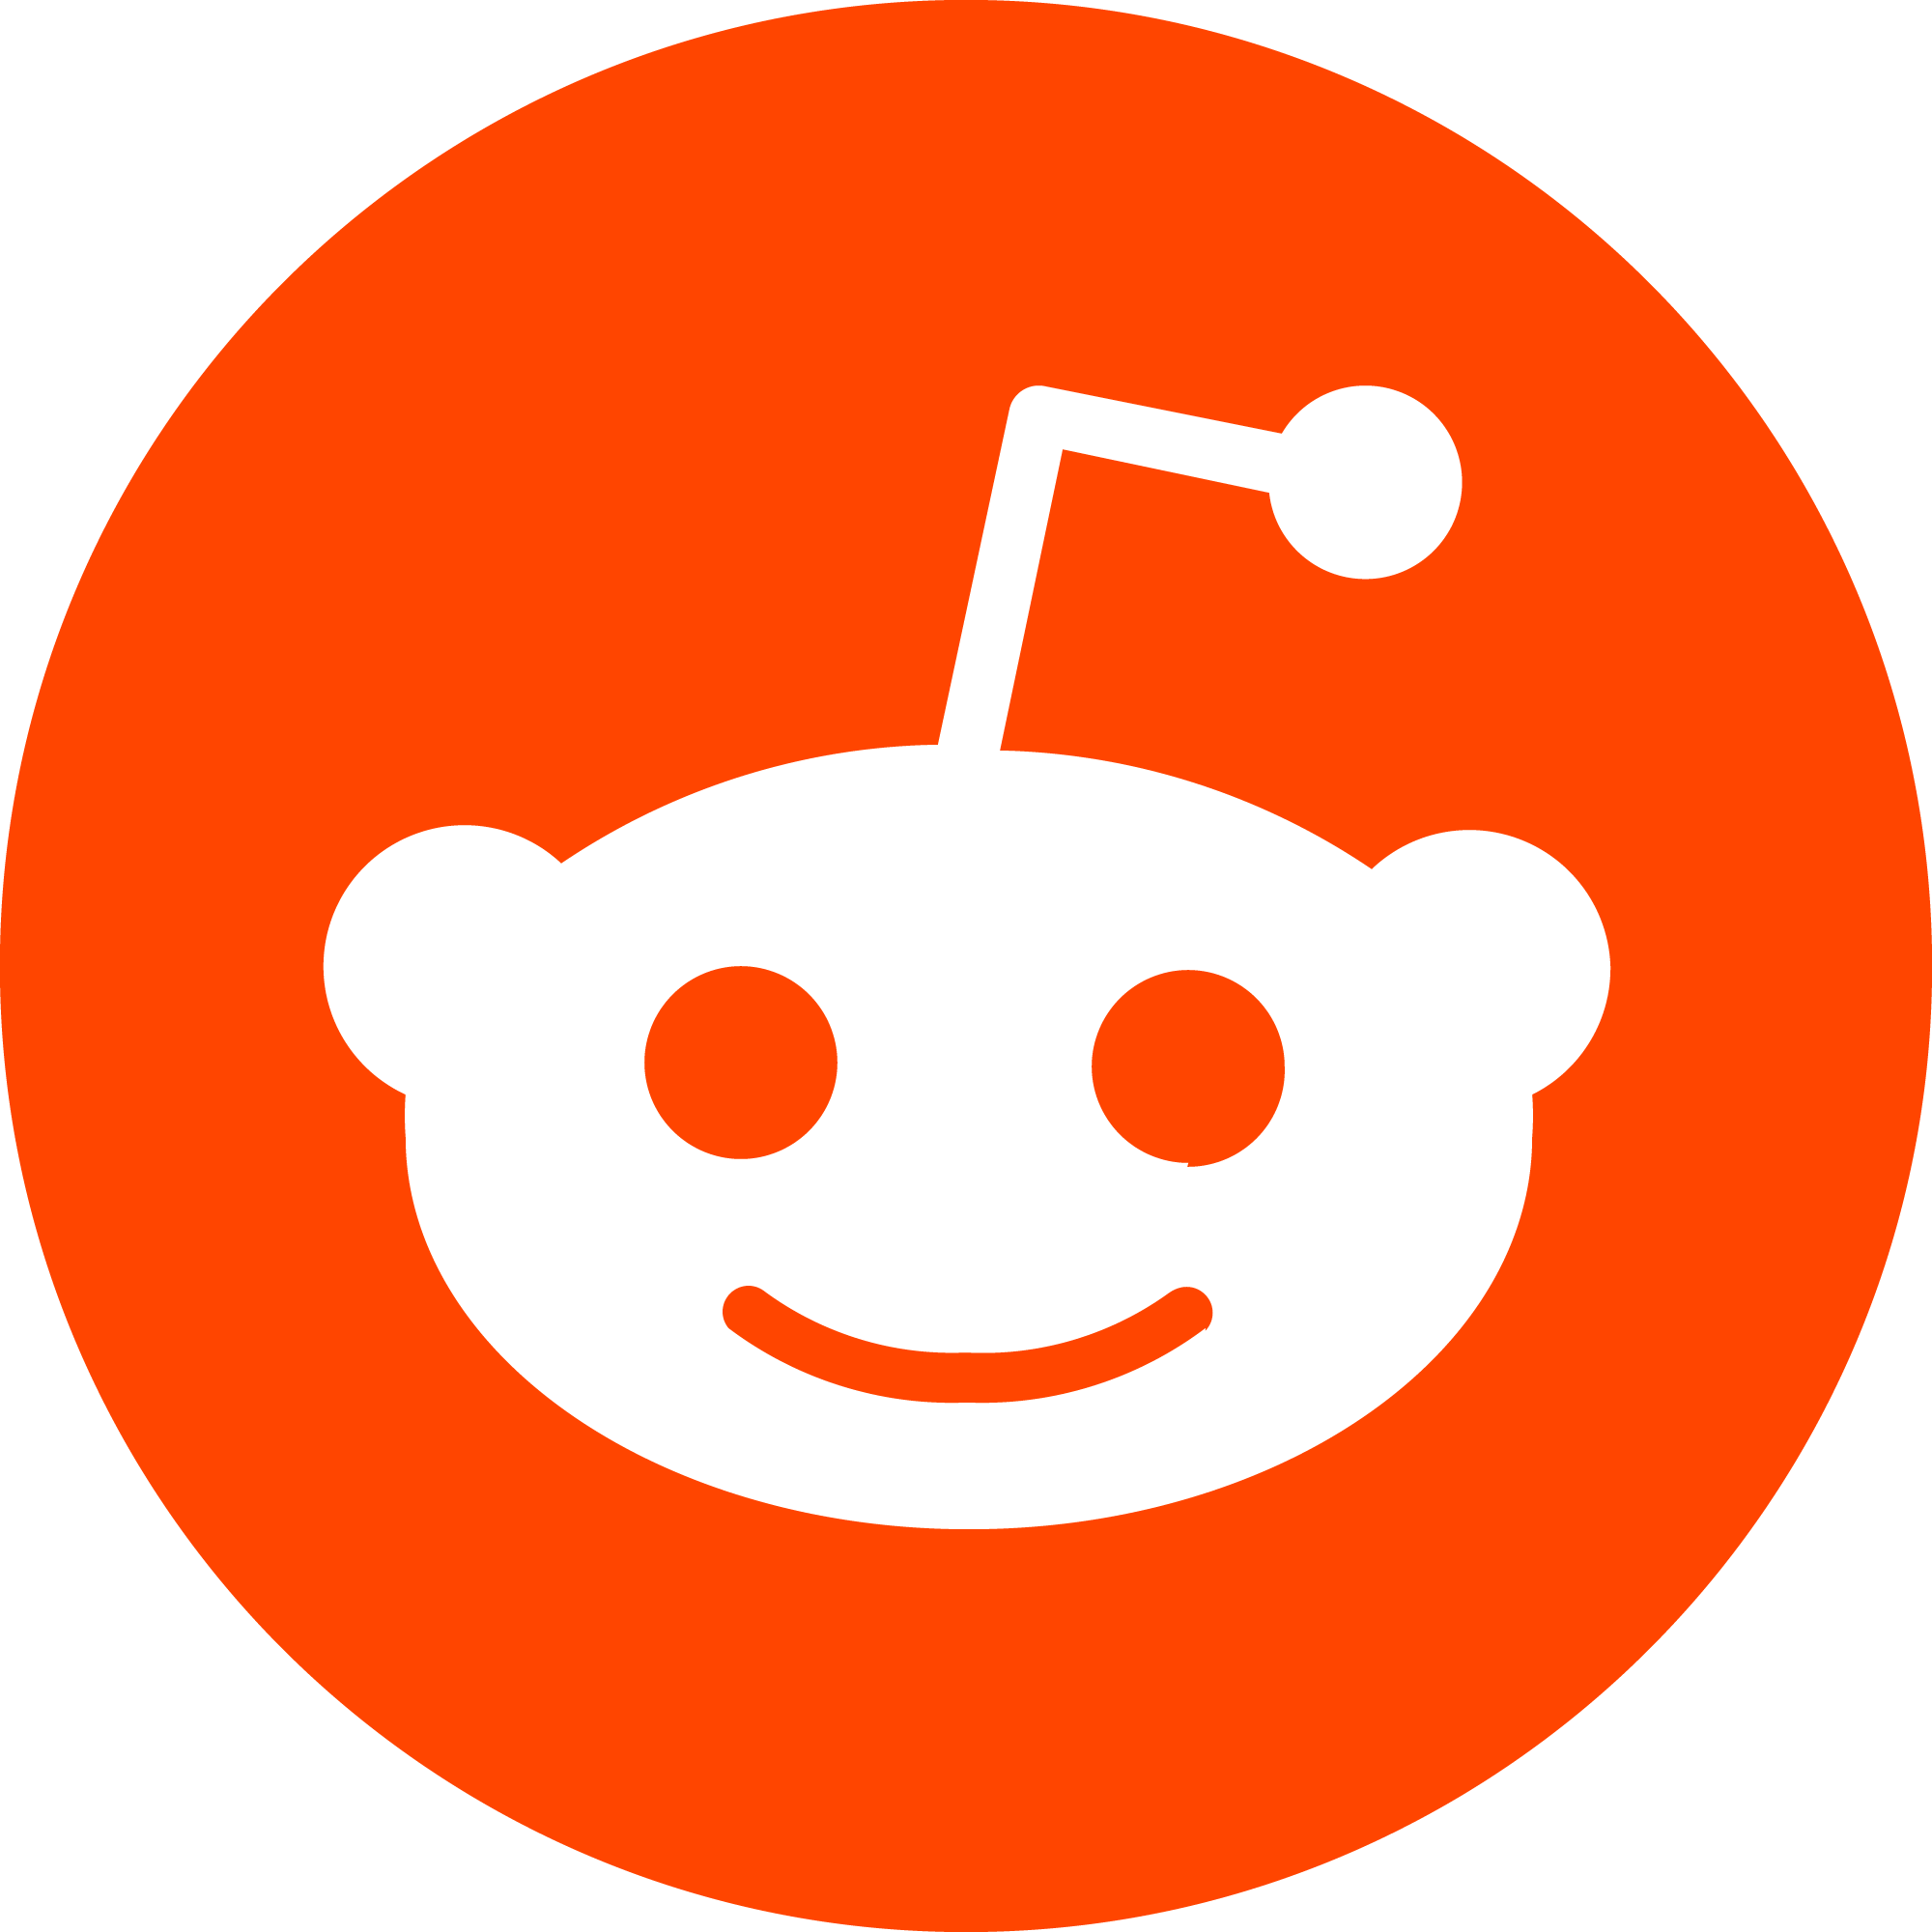
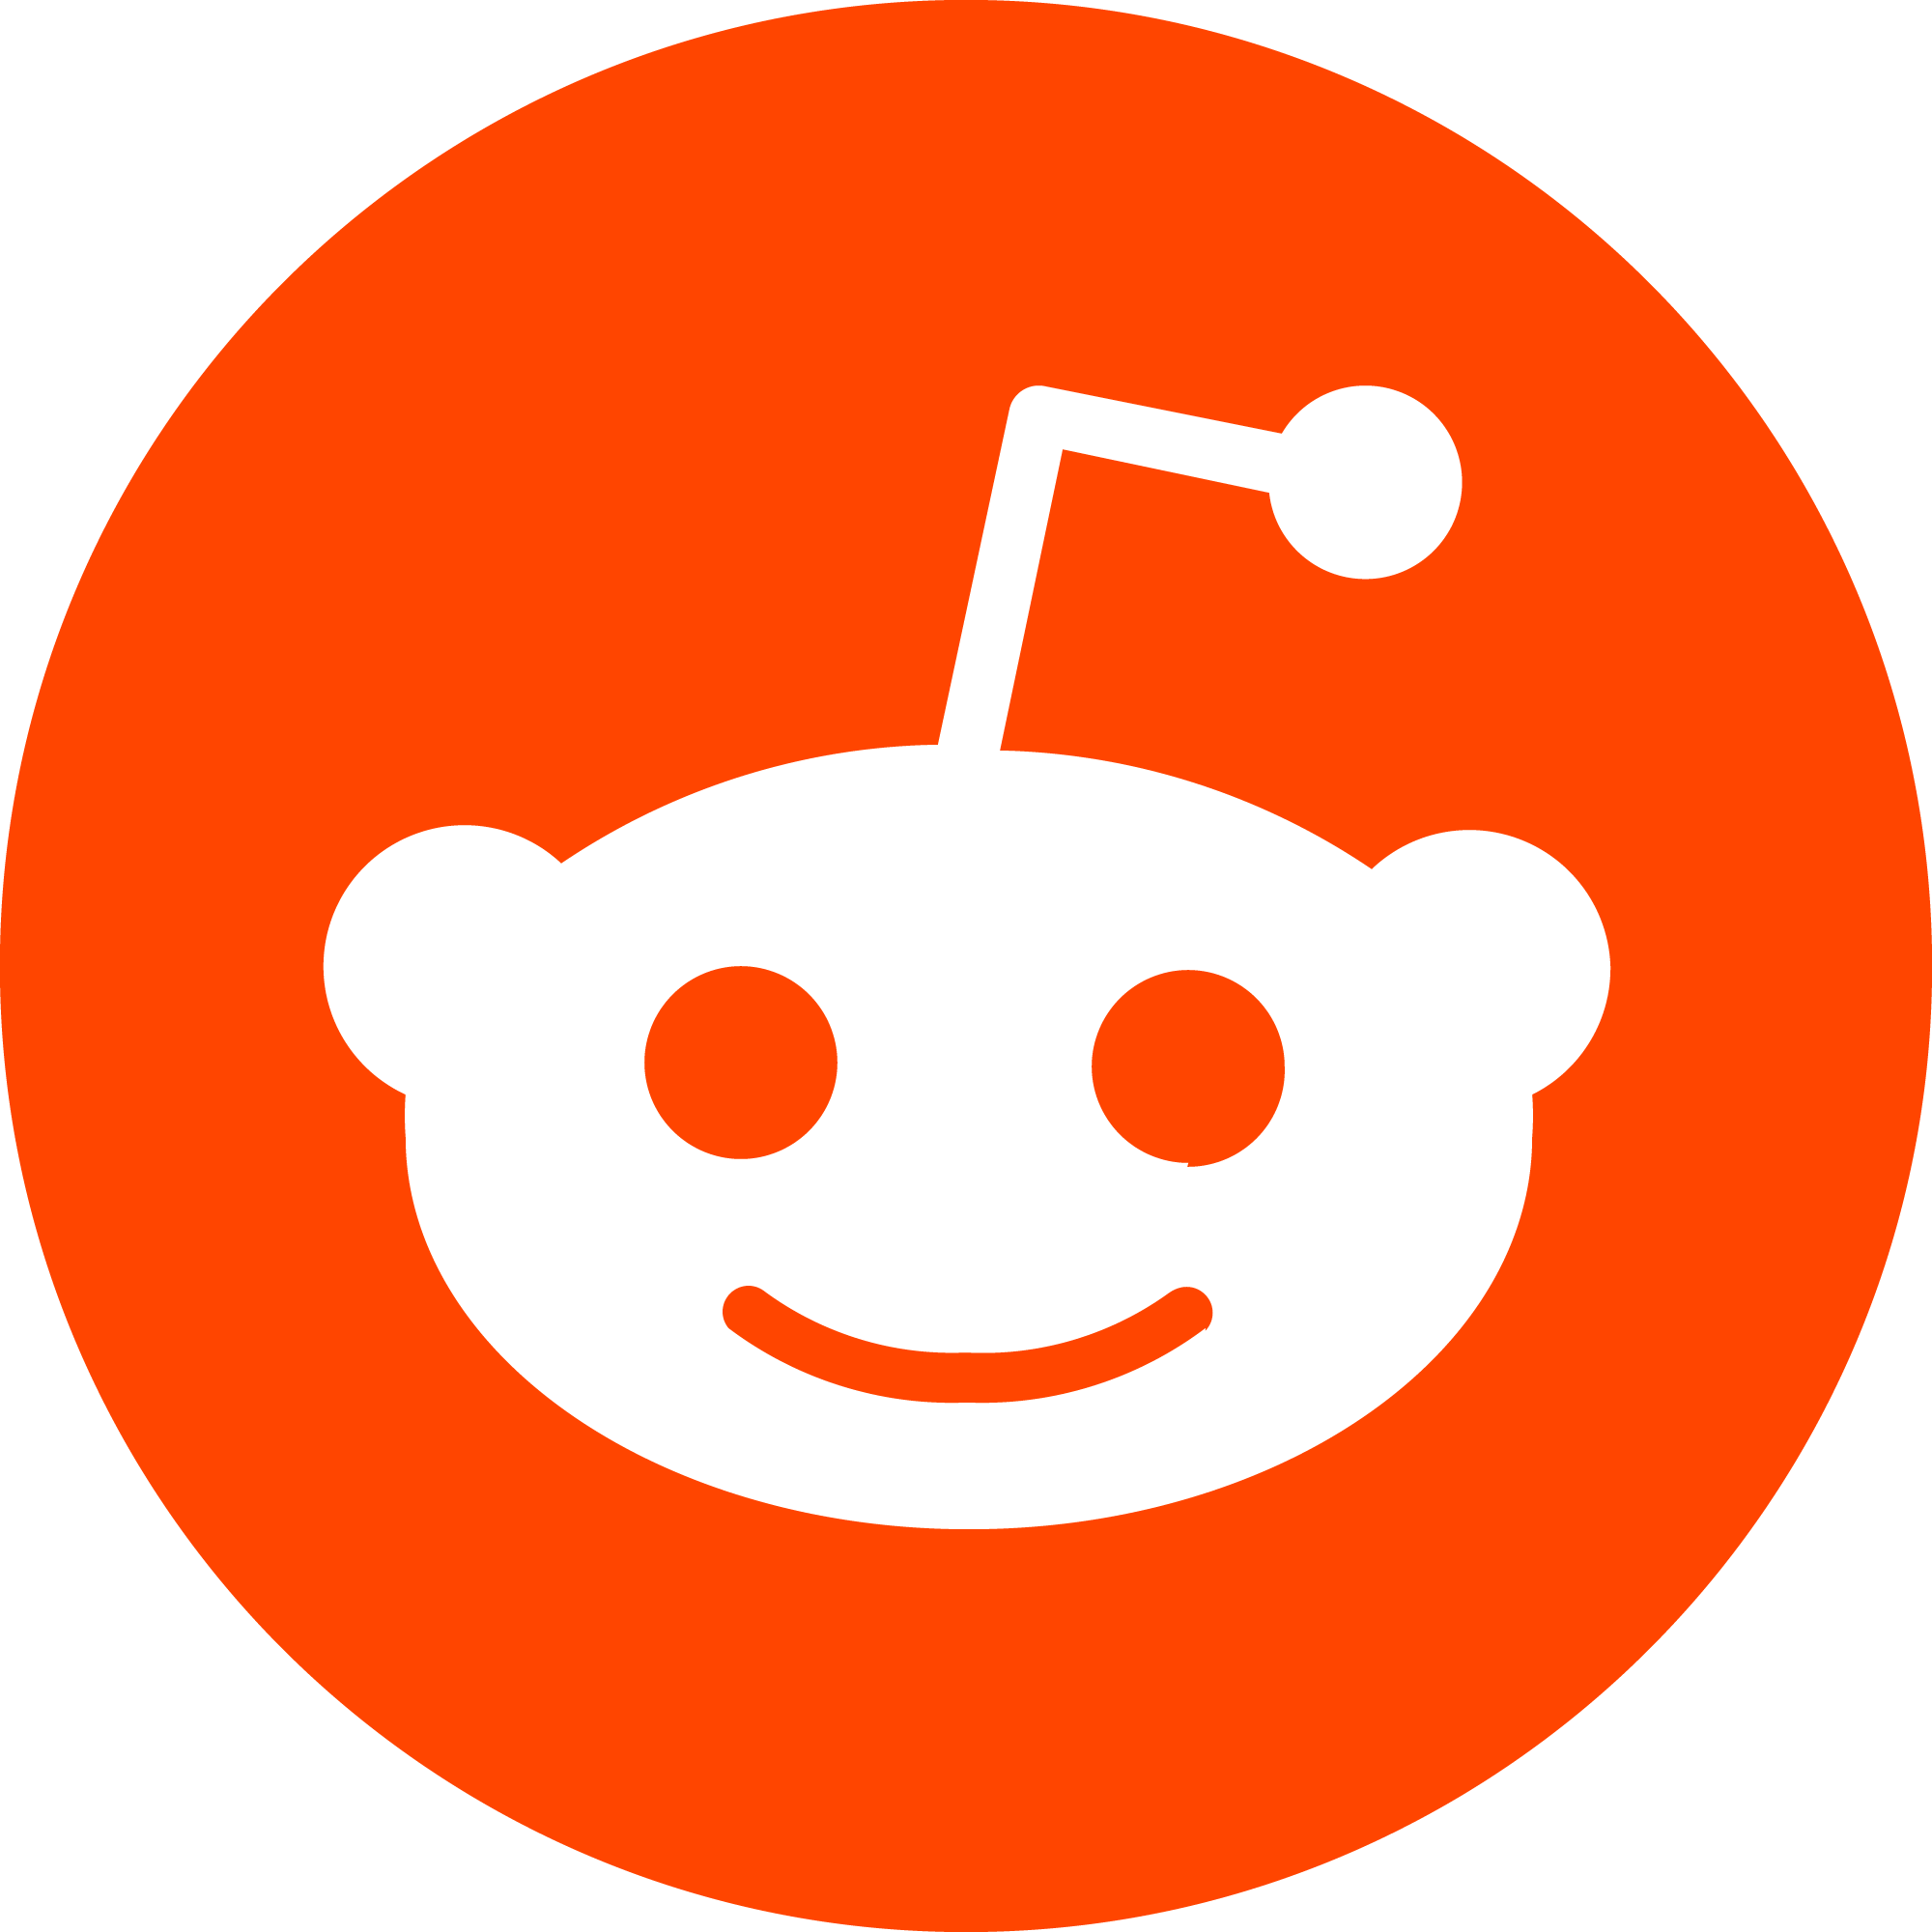

## 1. Setup and Imports

In [16]:
!pip install sklearn-crfsuite

In [17]:
import numpy as np
import pandas as pd
from nltk.stem import WordNetLemmatizer
import re
import string
import sklearn_crfsuite
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import defaultdict

/kaggle/input/sentiwords/negative-words1.txt
/kaggle/input/sentiwords/positive-words.txt
/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv
/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Reddit_Data.csv


## 2. Data Preprocessing
### a) Loading the data
The first step is to load the two data files (Reddit and Twitter) and merge it into one for more convenience.

In [18]:
# Loading the data
df_reddit = pd.read_csv('/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Reddit_Data.csv')
df_twitter = pd.read_csv('/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv')

#Merging the twitter and reddit datasets into one
df_twitter.rename(columns = {'clean_text':'clean_comment'}, inplace = True) # renaming the twitter columns like the reddit columns
print("Twitter dataset shape : ", df_twitter.shape,"\nReddit dataset shape : ",  df_reddit.shape)
#df = df_reddit.append(df_twitter).reset_index()
df = pd.concat([df_reddit, df_twitter], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True) # shuffling the reddit comments and tweets
print("Merged dataset shape : ", df.shape)
print(df.head())

Twitter dataset shape :  (162980, 2) 
Reddit dataset shape :  (37249, 2)
Merged dataset shape :  (200229, 2)
                                       clean_comment  category
0  seems like modi has given ahead will keep hot ...       1.0
1  those who are asking lakhs from modi kindly wa...       1.0
2  “chowkidar” tejasvi surya general secretary bj...       1.0
3  air india boarding pass with modi’ photo kicks...       0.0
4  congress led upa surgical strike dont air stri...       0.0


### b) Cleaning the data
Now we need to "clean" the data by removing all the unecessary words, noise, abbreviations, stopwords, etc.

In [19]:
# Dictionnary of all abbreviations we're going to use for the cleaning
abbreviations = {"$" : " dollar ","€" : " euro ","4ao" : "for adults only","a.m" : "before midday",
    "a3" : "anytime anywhere anyplace","aamof" : "as a matter of fact","acct" : "account",
    "adih" : "another day in hell","afaic" : "as far as i am concerned","afaict" : "as far as i can tell","afaik" : "as far as i know",
    "afair" : "as far as i remember","afk" : "away from keyboard","app" : "application",
    "approx" : "approximately","apps" : "applications","asap" : "as soon as possible","asl" : "age, sex, location","atk" : "at the keyboard",
    "ave." : "avenue","aymm" : "are you my mother","ayor" : "at your own risk", "b&b" : "bed and breakfast","b+b" : "bed and breakfast","b.c" : "before christ",
    "b2b" : "business to business","b2c" : "business to customer","b4" : "before","b4n" : "bye for now",
    "b@u" : "back at you","bae" : "before anyone else","bak" : "back at keyboard","bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation","bbias" : "be back in a second","bbl" : "be back later","bbs" : "be back soon",
    "be4" : "before","bfn" : "bye for now","blvd" : "boulevard","bout" : "about","brb" : "be right back",
    "bros" : "brothers","brt" : "be right there","bsaaw" : "big smile and a wink","btw" : "by the way",
    "bwl" : "bursting with laughter","c/o" : "care of","cet" : "central european time","cf" : "compare",
    "cia" : "central intelligence agency","csl" : "can not stop laughing","cu" : "see you","cul8r" : "see you later",
    "cv" : "curriculum vitae","cwot" : "complete waste of time","cya" : "see you","cyt" : "see you tomorrow",
    "dae" : "does anyone else","dbmib" : "do not bother me i am busy","diy" : "do it yourself","dm" : "direct message",
    "dwh" : "during work hours","e123" : "easy as one two three",
    "eet" : "eastern european time","eg" : "example","embm" : "early morning business meeting","encl" : "enclosed",
    "encl." : "enclosed","etc" : "and so on","faq" : "frequently asked questions","fawc" : "for anyone who cares","fb" : "facebook",
    "fc" : "fingers crossed","fig" : "figure","fimh" : "forever in my heart", "ft." : "feet",
    "ft" : "featuring","ftl" : "for the loss","ftw" : "for the win","fwiw" : "for what it is worth",
    "fyi" : "for your information","g9" : "genius","gahoy" : "get a hold of yourself","gal" : "get a life",
    "gcse" : "general certificate of secondary education","gfn" : "gone for now","gg" : "good game",
    "gl" : "good luck","glhf" : "good luck have fun","gmt" : "greenwich mean time","gmta" : "great minds think alike",
    "gn" : "good night","g.o.a.t" : "greatest of all time","goat" : "greatest of all time",
    "goi" : "get over it","gps" : "global positioning system","gr8" : "great","gratz" : "congratulations",
    "gyal" : "girl","h&c" : "hot and cold","hp" : "horsepower","hr" : "hour","hrh" : "his royal highness",
    "ht" : "height","ibrb" : "i will be right back","ic" : "i see","icq" : "i seek you","icymi" : "in case you missed it",
    "idc" : "i do not care","idgadf" : "i do not give a damn fuck","idgaf" : "i do not give a fuck","idk" : "i do not know",
    "ie" : "that is","i.e" : "that is","ifyp" : "i feel your pain","IG" : "instagram","iirc" : "if i remember correctly","ilu" : "i love you",
    "ily" : "i love you","imho" : "in my humble opinion","imo" : "in my opinion","imu" : "i miss you","iow" : "in other words",
    "irl" : "in real life","j4f" : "just for fun","jic" : "just in case","jk" : "just kidding","jsyk" : "just so you know",
    "l8r" : "later","lb" : "pound","lbs" : "pounds","ldr" : "long distance relationship","lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off","lol" : "laughing out loud","ltd" : "limited","ltns" : "long time no see","m8" : "mate",
    "mf" : "motherfucker","mfs" : "motherfuckers","mfw" : "my face when","mofo" : "motherfucker","mph" : "miles per hour",
    "mr" : "mister","mrw" : "my reaction when","ms" : "miss","mte" : "my thoughts exactly","nagi" : "not a good idea",
    "nbc" : "national broadcasting company","nbd" : "not big deal","nfs" : "not for sale","ngl" : "not going to lie","nhs" : "national health service",
    "nrn" : "no reply necessary","nsfl" : "not safe for life","nsfw" : "not safe for work","nth" : "nice to have","nvr" : "never",
    "nyc" : "new york city","oc" : "original content","og" : "original","ohp" : "overhead projector","oic" : "oh i see",
    "omdb" : "over my dead body","omg" : "oh my god","omw" : "on my way","p.a" : "per annum","p.m" : "after midday","pm" : "prime minister",
    "poc" : "people of color","pov" : "point of view","pp" : "pages","ppl" : "people","prw" : "parents are watching","ps" : "postscript",
    "pt" : "point","ptb" : "please text back","pto" : "please turn over","qpsa" : "what happens","ratchet" : "rude",
    "rbtl" : "read between the lines","rlrt" : "real life retweet", "rofl" : "rolling on the floor laughing","roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off","rt" : "retweet","ruok" : "are you ok","sfw" : "safe for work","sk8" : "skate",
    "smh" : "shake my head","sq" : "square","srsly" : "seriously", "ssdd" : "same stuff different day","tbh" : "to be honest","tbs" : "tablespooful",
    "tbsp" : "tablespooful","tfw" : "that feeling when","thks" : "thank you","tho" : "though","thx" : "thank you",
    "tia" : "thanks in advance","til" : "today i learned","tl;dr" : "too long i did not read","tldr" : "too long i did not read","tmb" : "tweet me back",
    "tntl" : "trying not to laugh","ttyl" : "talk to you later","u" : "you","u2" : "you too","u4e" : "yours for ever","utc" : "coordinated universal time","w/" : "with",
    "w/o" : "without","w8" : "wait","wassup" : "what is up","wb" : "welcome back","wtf" : "what the fuck","wtg" : "way to go",
    "wtpa" : "where the party at","wuf" : "where are you from","wuzup" : "what is up","wywh" : "wish you were here",
    "yd" : "yard","ygtr" : "you got that right","ynk" : "you never know","zzz" : "sleeping bored and tired"
}

Bellow is the list of all the functions we're going to use to clean the data :

In [20]:
# Remove all URLs, replace by URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',str(text))

# Remove HTML beacon
def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# Change an abbreviation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    words = text.split()
    return ' '.join([abbreviations.get(word.lower(), word) for word in words])

# Remove @ and mention, replace by USER
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)
                     
# Remove numbers, replace it by NUMBER
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

# Replace some others smileys with SADFACE
def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

# Replace some smileys with SMILE
def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'SMILE', text)

# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

# Factorize elongated words, add ELONG
def remove_elongated_words(text):
    rep = re.compile(r'\b(\S*?)([a-z])\2{2,}\b')
    return rep.sub(r'\1\2 ELONG', text)

# Factorize repeated punctuation, add REPEAT
def remove_repeat_punct(text):
    rep = re.compile(r'([!?.]){2,}')
    return rep.sub(r'\1 REPEAT', text)

# Remove all punctuations
def remove_all_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

# Remove punctuations
def remove_punct(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" 
    for p in punctuations:
        text = text.replace(p, f' {p} ')

    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')   
    return text

# Remove all english stopwords
def remove_stopwords(text):
    stop_words = {'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 
'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 
'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 
'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing',
 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 
'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 
'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 
'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 
'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 
's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y',
 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 
'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn',
 "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 
'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"}
    return ' '.join([word for word in text.split() if word not in stop_words])

def lemmatization(text):
    lm= WordNetLemmatizer()
    text = ' '.join([lm.lemmatize(word, pos='v') for word in text.split()])
    return text

In [21]:
# Function combining all the previous cleaning functions
def clean_text(text):
    # Remove non text
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)
    # Remove  smileys
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
    # Remove numbers and mentions
    text = remove_mention(text)
    text = remove_number(text)
    # Replace abbreviations
    text = replace_abbrev(text)
    # Remove repeated puntuations / words
    text = remove_elongated_words(text)
    text = remove_repeat_punct(text)
    # Remove stopwords + lemmatization
    text = remove_stopwords(text)
    text = lemmatization(text)
    return text

# We apply the function we just defined to clean the data
df['clean_comment'] = df['clean_comment'].apply(clean_text)

# Removing the misclassified data, and the empty data (because the stopwords removal may have
# turned previously complete sentences into empty ones).
before = len(df)
df = df[df['category'].isin([-1.0, 0.0, 1.0]) & (df['clean_comment'].str.len() > 0)]

after = len(df)
print(f"{before - after} comments were removed because they were either not properly classified or empty.")

print("\nExample of cleaned data :\n", df.head())

344 comments were removed because they were either not properly classified or empty.

Example of cleaned data :
                                        clean_comment  category
0       seem like modi give ahead keep hot april may       1.0
1  ask lakhs modi kindly watch video promise lakh...       1.0
2  chowkidar tejasvi surya general secretary bjp ...       1.0
3  air india board pass modi photo kick row later...       0.0
4  congress lead upa surgical strike dont air str...       0.0


## 3. Featurization
For each word in a sentence, we extract a set of features that aim to capture both lexical and contextual information. These features help the CRF model learn patterns that may indicate sentiment. Below is a brief explanation of each feature:

- **bias**: A constant value (`1.0`) used as an intercept feature. It helps the model learn a general bias term, independent of the input.

- **word.lower()**: The word converted to lowercase. This reduces the sparsity of features caused by casing variations (e.g., "Good" vs "good").

- **word[-3:]**: The last three characters of the word (a suffix). Suffixes often carry useful semantic or grammatical information, such as "-ing", "-ly", "-ful", etc.

- **word.isupper()**: Boolean indicating whether the word is in uppercase. Uppercase words can indicate emphasis or specific entities (e.g., "LOVE", "HATE").

- **word.isdigit()**: Boolean indicating whether the word is numeric. Numbers may be relevant in certain expressions (e.g., "100%", "5 stars").

- **word.sentiment**: A manually assigned label (positive, negative, or neutral) based on predefined sentiment lexicons. This provides prior knowledge from external sources.

#### Contextual Features

In addition to features for the current word, we also include features from surrounding context:

- **Previous word features**: The same set of features (e.g., `prev_word.lower()`, `prev_word.isupper()`, etc.) extracted from the preceding word, if it exists. These help the model capture local sequential patterns.

- **Next word features**: Similar features from the next word in the sentence, providing forward context.

- **BOS (Beginning of Sentence)**: A boolean flag set to `True` if the current word is the first word in the sentence.

- **EOS (End of Sentence)**: A boolean flag set to `True` if the current word is the last word in the sentence.

Together, these features allow the CRF model to learn both the local structure of words and their relationships within the sentence.

In [22]:
# First, we load the positive and negative words
def txt_to_dico(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        word_set = {line.strip() for line in file}
    return word_set

positive_words = txt_to_dico('/kaggle/input/sentiwords/positive-words.txt')
negative_words = txt_to_dico('/kaggle/input/sentiwords/negative-words1.txt')

print("\nExample of positive words :", list(positive_words)[:10])
print("\nExample of negative words :", list(negative_words)[:10])


Example of positive words : ['gladden', 'gratified', 'entrust', 'vivacious', 'promised', 'glee', 'wonderfully', 'agility', 'reputation', 'judicious']

Example of negative words : ['involuntarily', 'unbearablely', 'evil', 'snobish', 'timidly', 'indolent', 'bs', 'cautionary', 'crippling', 'imbroglio']


In [23]:
#Then we write a function to determine wether a word is positive, neutral or negative
def label_word(word):
    if word in positive_words:
        return '1.0'
    elif word in negative_words:
        return '-1.0'
    else:
        return '0'

# Example of use
ExampleSentence = df['clean_comment'][0].split()
labeled_sentence = {(word, label_word(word)) for word in ExampleSentence}
print("Example sentence : ",df['clean_comment'][0])
print("\nLabelization of each word of the sentence (unordered) : ",labeled_sentence)

Example sentence :  seem like modi give ahead keep hot april may

Labelization of each word of the sentence (unordered) :  {('may', '0'), ('hot', '1.0'), ('modi', '0'), ('give', '0'), ('like', '1.0'), ('keep', '0'), ('seem', '0'), ('april', '0'), ('ahead', '0')}


In [24]:
def word2features(sentence, i):
    word = sentence[i]
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word.isupper()': word.isupper(),
        'word.sentiment': label_word(word),
    }
    if i > 0:
        prev_word = sentence[i-1]
        features.update({
            'prev_word.lower()': prev_word.lower(),
            'prev_word.isupper()': prev_word.isupper(),
            'prev_word.sentiment': label_word(prev_word),
        })
    else:
        features['BOS'] = True  # Beginning of Sentence

    if i < len(sentence)-1:
        next_word = sentence[i+1]
        features.update({
            'next_word.lower()': next_word.lower(),
            'next_word.isupper()': next_word.isupper(),
            'next_word.sentiment': label_word(next_word),
        })
    else:
        features['EOS'] = True  # End of Sentence

    return features

def sent2features(sentence):
    return [word2features(sentence, i) for i in range(len(sentence))]

def sent2labels(sentence):
    return [word2features(sentence, i)['word.sentiment'] for i in range(len(sentence))]

# Example of cleaned sentence
ExampleFeatures = [word2features(ExampleSentence, i) for i in range(len(ExampleSentence))]

# Print the extracted caracteristics
for i, feature in enumerate(ExampleFeatures):
    print(f"Word: {ExampleSentence[i]}")
    print(f"Caracteristics: {feature}\n")

Word: seem
Caracteristics: {'bias': 1.0, 'word.lower()': 'seem', 'word[-3:]': 'eem', 'word.isupper()': False, 'word.sentiment': '0', 'BOS': True, 'next_word.lower()': 'like', 'next_word.isupper()': False, 'next_word.sentiment': '1.0'}

Word: like
Caracteristics: {'bias': 1.0, 'word.lower()': 'like', 'word[-3:]': 'ike', 'word.isupper()': False, 'word.sentiment': '1.0', 'prev_word.lower()': 'seem', 'prev_word.isupper()': False, 'prev_word.sentiment': '0', 'next_word.lower()': 'modi', 'next_word.isupper()': False, 'next_word.sentiment': '0'}

Word: modi
Caracteristics: {'bias': 1.0, 'word.lower()': 'modi', 'word[-3:]': 'odi', 'word.isupper()': False, 'word.sentiment': '0', 'prev_word.lower()': 'like', 'prev_word.isupper()': False, 'prev_word.sentiment': '1.0', 'next_word.lower()': 'give', 'next_word.isupper()': False, 'next_word.sentiment': '0'}

Word: give
Caracteristics: {'bias': 1.0, 'word.lower()': 'give', 'word[-3:]': 'ive', 'word.isupper()': False, 'word.sentiment': '0', 'prev_word.

## 4. CRF Model Training

### Sentence-Level Label Assignment

The CRF model is trained to assign a label to **each word** in a sentence. However, since our task is to classify the **entire sentence** as either:

- `-1.0` → Negative  
- `0.0`  → Neutral  
- `1.0`  → Positive

we need a way to **aggregate word-level predictions into a single sentence-level label**.

#### ➤ Strategy: Majority Voting

- For each sentence, we collect the predicted labels for all its words (e.g., `["0.0", "1.0", "1.0", "0.0"]`).
- We then apply **majority voting** :
  - The most frequent label among the words becomes the **global label** of the sentence.
- As for the training, each word of a sentence will be given the label of the sentence.

In [25]:
CleanedSentences = df['clean_comment'][:].apply(lambda x: x.split())

Labels = df['category'][:]

X = [sent2features(s) for s in CleanedSentences]
y = [[str(label)]*len(sentence) for sentence, label in zip(CleanedSentences, Labels)]

# Split : 80% train / 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the crf model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X_train, y_train)
y_pred = crf.predict(X_test)

## 5. Results Analysis

In [26]:
y_pred_global = [Counter(seq).most_common(1)[0][0] for seq in y_pred]
y_test_global = [Counter(seq).most_common(1)[0][0] for seq in y_test]
print(classification_report(y_test_global, y_pred_global))

              precision    recall  f1-score   support

        -1.0       0.82      0.76      0.79      8777
         0.0       0.85      0.92      0.88     13606
         1.0       0.89      0.87      0.88     17594

    accuracy                           0.86     39977
   macro avg       0.85      0.85      0.85     39977
weighted avg       0.86      0.86      0.86     39977



### Model Performance Summary

The CRF model achieved relatively balanced precision, recall, and F1-score for the **neutral** and **positive** classes. However, performance on the **negative** class is noticeably lower across all three metrics. This drop may be attributed to the class's lower support — meaning fewer training examples were available for negative comments compared to the other classes.

Despite this, the overall performance remains solid. The model is able to correctly classify the majority of sentences, demonstrating that the CRF is capable of capturing key sentiment patterns in the data.

Further improvement could be achieved by balancing the dataset or incorporating richer features to better capture negative sentiment, which is often expressed more subtly or with sarcasm.

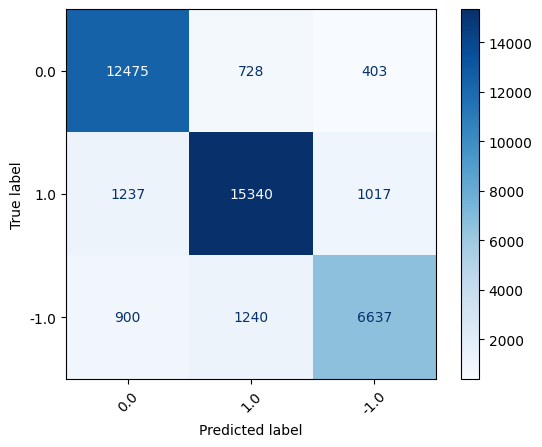

In [29]:
cm = confusion_matrix(y_test_global, y_pred_global, labels=crf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=crf.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)

### Confusion Matrix Analysis

From the confusion matrix, we observe that most predictions fall on the diagonal, indicating that the model correctly classified the majority of samples.

However, there is a slight tendency to misclassify negative comments as positive. This may be due to :
- Informal or sarcastic language often used in social media,
- Ambiguous vocabulary that appears in both positive and negative contexts,
- Imbalanced class distribution in the dataset.


In [32]:
def print_top_features(crf, label, top_n=7):
    weights = defaultdict(float)
    for (attr, lbl), weight in crf.state_features_.items():
        if lbl == label:
            weights[attr] = weight
    for attr, weight in sorted(weights.items(), key=lambda x: -abs(x[1]))[:top_n]:
        print(f"{attr}: {weight:.3f}")

print("\nTop features for positive sentiment:")
print_top_features(crf, "1.0")
print("\nTop features for negative sentiment:")
print_top_features(crf, "-1.0")
print("\nTop features for neutral sentiment:")
print_top_features(crf, "0.0")
print("\n")


Top features for positive sentiment:
prev_word.lower():divisions: 4.634
word.lower():excellent: 4.145
word.lower():awesome: 4.145
word.lower():brilliant: 3.773
word.lower():impressive: 3.677
word.lower():cute: 3.639
word[-3:]:kod: 3.153

Top features for negative sentiment:
prev_word.lower():phoney: 3.964
word.lower():phoney: 3.955
next_word.lower():phoney: 3.941
word.lower():atrocious: 3.247
prev_word.lower():populace: -3.217
word.lower():awful: 3.069
prev_word.lower():bharatmata: 2.972

Top features for neutral sentiment:
word[-3:]:bli: 4.042
prev_word.lower():cockroach: 3.882
word.lower():typical: -3.684
word.lower():jeolous: 3.631
prev_word.lower():jeolous: 3.597
word.lower():cool: -3.581
next_word.lower():simulations: 3.481




### Feature Importance Analysis

The CRF model reveals insightful patterns regarding the features most predictive of each sentiment class.

For **positive sentiment**, the most influential features include strongly positive adjectives such as *excellent*, *awesome*, *brilliant*, and *impressive*. These are clear lexical indicators of positive tone. Contextual features like `prev_word.lower():divisions` also suggest the model captures useful sequential dependencies.

In the **negative class**, the word *phoney* stands out across positions (previous, current, next), indicating its consistent association with negative sentiment. Other negatively weighted terms like *atrocious* and *awful* further support the model’s ability to identify strongly negative language.

**Neutral sentiment** appears to rely more on contextual or ambiguous terms such as *typical* and the suffix *-bli*, with less polarized vocabulary. Some influence from misspellings (e.g., *jeolous*) and technical terms (*simulations*) suggests a domain-specific effect.

These results confirm the CRF model's strength in leveraging both lexical features and surrounding context to distinguish between sentiment classes.


### Reproducibility Note

To ensure consistent results across runs, we fixed the `random_state` parameter to `42` when splitting and shuffling the dataset and, where applicable, in model configuration. This allows for reproducibility of the train-test split and any randomized operations.

If needed, the `random_state` value can be modified to assess the stability of the model's performance under different data partitions (CTRL+F and type "random_state" to find the occurences of this parameter).
